In [1]:
import random
import scipy
import math

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import community


from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import louvain_communities, louvain_partitions
from networkx.generators.community import LFR_benchmark_graph # here do not use algorithms


from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import mutual_info_score


plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

# Part 1: Centrality [30 points]

### 1.1

In [2]:
def load_graphs():
    """
    
    Returns:
    G_airport: NetworkX Graph Object
    G_yeast: NetworkX Graph Object
    
    """

   # Define file paths
    airport_file = os.path.join("/Users/zklou/Desktop/Assignment3/", "US_airports.txt")
    yeast_file = os.path.join("/Users/zklou/Desktop/Assignment3/", "Yeast.txt")
    
    # Load the airport network with weights from the 3rd column
    G_airport = nx.read_edgelist(airport_file, nodetype=int, data=(('weight', float),))
    
    # Load the yeast interaction network (assuming similar format)
    G_yeast = nx.read_edgelist(yeast_file, nodetype=int, data=(('weight', float),))

    return G_airport, G_yeast

### 1.2

In [3]:
import networkx as nx
import numpy as np

def top_10_nodes(G):
    """
    Compute six centrality measures and return the top 10 nodes for each.

    Inputs:
    G: NetworkX Graph Object

    Returns:
    top_10_nodes_dict: dict[list[int]]
    """
    
    # Compute Eigenvector centrality
    eigen = nx.eigenvector_centrality(G, max_iter=1000)

    # Compute Katz centrality: Calculate α dynamically as 1 / λ_max
    try:
        # Calculate the largest eigenvalue (λ_max) of the adjacency matrix
        largest_eigenvalue = max(np.linalg.eigvals(nx.adjacency_matrix(G).todense()).real)
        alpha_value = 1 / largest_eigenvalue  # Safe α value
        
        # Compute Katz centrality
        katz = nx.katz_centrality(G, alpha=alpha_value, max_iter=2000)
    
    except nx.PowerIterationFailedConvergence:
        print("Warning: Katz centrality failed to converge with α =", alpha_value)
        katz = nx.katz_centrality(G, alpha=0.9 * alpha_value, max_iter=3000)  # Reduce α for better convergence
    
    except Exception as e:
        print("Error computing Katz centrality:", e)
        katz = {}

    # Compute PageRank centrality
    page_rank = nx.pagerank(G)

    # Convert weighted graph to unweighted for closeness and betweenness
    G_unweighted = nx.Graph(G)  # Copy the graph without weights

    # Compute Closeness centrality (unweighted)
    closeness = nx.closeness_centrality(G_unweighted, wf_improved=False)  # Ensure it follows lecture definition

    # Compute Harmonic centrality
    harmonic = nx.harmonic_centrality(G)

    # Compute Betweenness centrality (unweighted)
    betweenness = nx.betweenness_centrality(G_unweighted)

    # Sort and select the top 10 nodes for each centrality measure
    top_10_nodes_dict = {
        'eigen': sorted(eigen, key=eigen.get, reverse=True)[:10],
        'katz': sorted(katz, key=katz.get, reverse=True)[:10] if katz else [],
        'page_rank': sorted(page_rank, key=page_rank.get, reverse=True)[:10],
        'closeness': sorted(closeness, key=closeness.get, reverse=True)[:10],
        'harmonic': sorted(harmonic, key=harmonic.get, reverse=True)[:10],
        'betweenness': sorted(betweenness, key=betweenness.get, reverse=True)[:10],
    }

    return top_10_nodes_dict


### 1.3

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_similarity_matrix(top_nodes_dict):
    """
    Compute the Jaccard similarity matrix for the top 10 nodes of different centrality measures.

    Inputs:
    top_nodes_dict: dict[list[int]] - Dictionary mapping centrality measures to their top 10 nodes.

    Returns:
    similarity_matrix: np.array - Jaccard similarity matrix.
    """
    # Initialize the similarity matrix
    centralities = list(top_nodes_dict.keys())
    n = len(centralities)
    similarity_matrix = np.zeros((n, n))

    # Calculate Jaccard similarity for each pair of centrality measures
    for i, measure_1 in enumerate(centralities):
        for j, measure_2 in enumerate(centralities):
            set_1 = set(top_nodes_dict[measure_1])
            set_2 = set(top_nodes_dict[measure_2])
            
            # Compute Jaccard Similarity: |A ∩ B| / |A ∪ B|
            intersection = len(set_1 & set_2)
            union = len(set_1 | set_2)

            # Avoid division by zero
            similarity_matrix[i, j] = intersection / union if union != 0 else 0.0

    return similarity_matrix

def plot_similarity_heatmap(similarity_matrix, data_name, save=False):
    """
    Plot and save a heatmap of the similarity matrix with actual values.

    Inputs:
    similarity_matrix: np.array - Jaccard similarity matrix.
    data_name: str - Name of the dataset (e.g., "Airport", "Yeast").
    save: bool - If True, saves the heatmap as an image.
    """
    plt.figure(figsize=(8, 8))

    # Define centrality measure names
    centrality_labels = ['Eigen', 'Katz', 'PageRank', 'Closeness', 'Harmonic', 'Betweenness']

    # Use seaborn for better visualization
    sns.heatmap(
        similarity_matrix, 
        annot=True, fmt=".2f", cmap="coolwarm",
        xticklabels=centrality_labels, yticklabels=centrality_labels,
        cbar_kws={'label': 'Jaccard Similarity'}
    )

    # Title
    plt.title(f"Jaccard Similarity Matrix for {data_name}")

    # Show plot
    plt.show()

    # Save if requested
    if save:
        plt.savefig(f"{data_name}_similarity_matrix.png", dpi=300, bbox_inches='tight')

    plt.close()


### 1.4

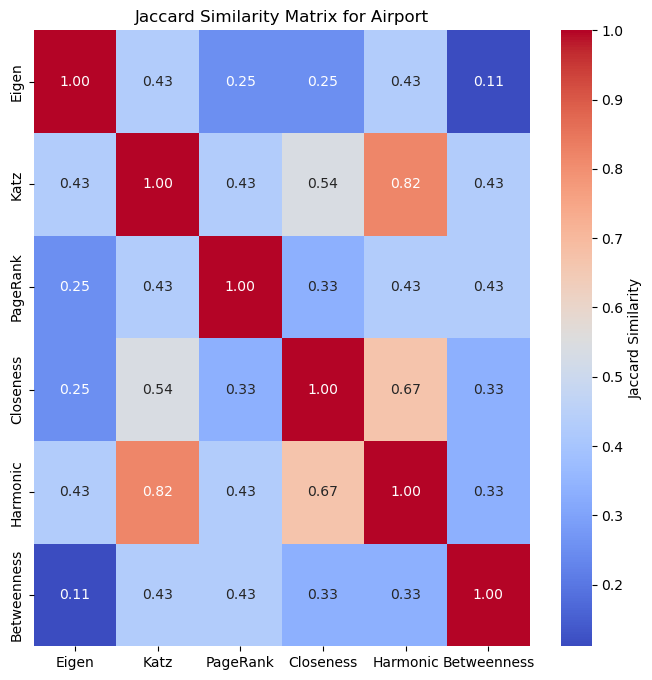

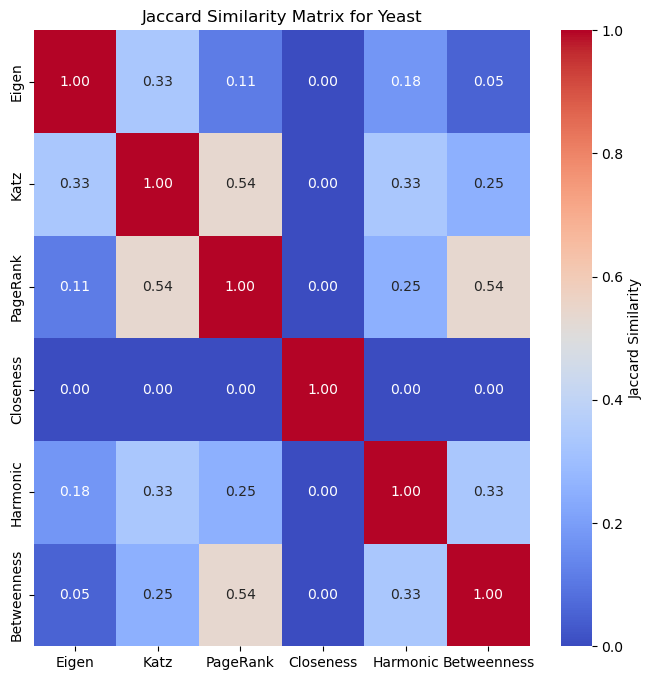

In [5]:
# Load the networks
G_airport, G_yeast = load_graphs()

# Get the top nodes
top_airport_nodes = top_10_nodes(G_airport)
top_yeast_nodes = top_10_nodes(G_yeast)

# Generate the similarity matrcies
node_similarity_airport = calculate_similarity_matrix(top_airport_nodes)
node_similarity_yeast = calculate_similarity_matrix(top_yeast_nodes)

# Generate the heatmaps
plot_similarity_heatmap(node_similarity_airport, 'Airport')
plot_similarity_heatmap(node_similarity_yeast, 'Yeast')


## Written Response for 1.4

Answer:

# Part 2: Community Detection with Zachary’s Karate Club [25 points]

### 2.1

In [6]:

def compute_cfinder_communities(G, k):
    """
    Inputs: G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """


    # Implement C-finder algorithm (assuming you have a custom implementation or external package)
    # For example, using a placeholder for C-finder, since the real implementation might depend on the method.
    community_assignments = []

    # Placeholder code: Replace with actual implementation or package usage
    for node in G.nodes():
        community_assignments.append(-1)  # Assign dummy value, replace with actual assignment

    return community_assignments

def compute_greedy_communities(G):
    """
    Inputs: G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """


    communities = list(greedy_modularity_communities(G))
    community_assignments = []

    # Assign community indices to nodes
    for i, community in enumerate(communities):
        for node in community:
            community_assignments.append((node, i))

    # Sort assignments by node
    community_assignments.sort(key=lambda x: x[0])
    return [community for _, community in community_assignments]
    

def compute_louvain_communities(G):
    """
    Inputs: G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """


    # Using the 'community' module for Louvain method
    partition = community.best_partition(G)
    
    # Convert partition dict into community assignment list
    community_assignments = [partition[node] for node in G.nodes()]
    return community_assignments


### 2.2

In [7]:
def plot_network_communities(G, community_assignments, algorithm_name, save=False):
    """
    Inputs:
    G: NetworkX Graph Object
    community_assignments: list[int]
    algorithm_name: str
    """
    random.seed(1)
    np.random.seed(1)

    # Set the community color mapping
    communities = set(community_assignments)  # Get unique community labels
    community_colors = {community: plt.cm.jet(i / len(communities)) for i, community in enumerate(communities)}
    
    # Map each node to its community's color
    node_colors = [community_colors[community] for community in community_assignments]
    
    # Create a layout for the graph
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    
    # Draw the graph with the community colors
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_size=300, with_labels=True, node_color=node_colors, font_size=10, font_weight='bold', edge_color='gray')
    
    # Add a title indicating which algorithm was used
    plt.title(f'{algorithm_name} - Network Communities', fontsize=14)
    
    plt.show()
    if save:
        plt.savefig(f'karate_communities_{algorithm_name}.png')
    plt.close()

Graph density: 0.1390
k=3, critical density=0.171499
k=4, critical density=0.308679
k=5, critical density=0.414124
Graph is very sparse, recommend using k=3


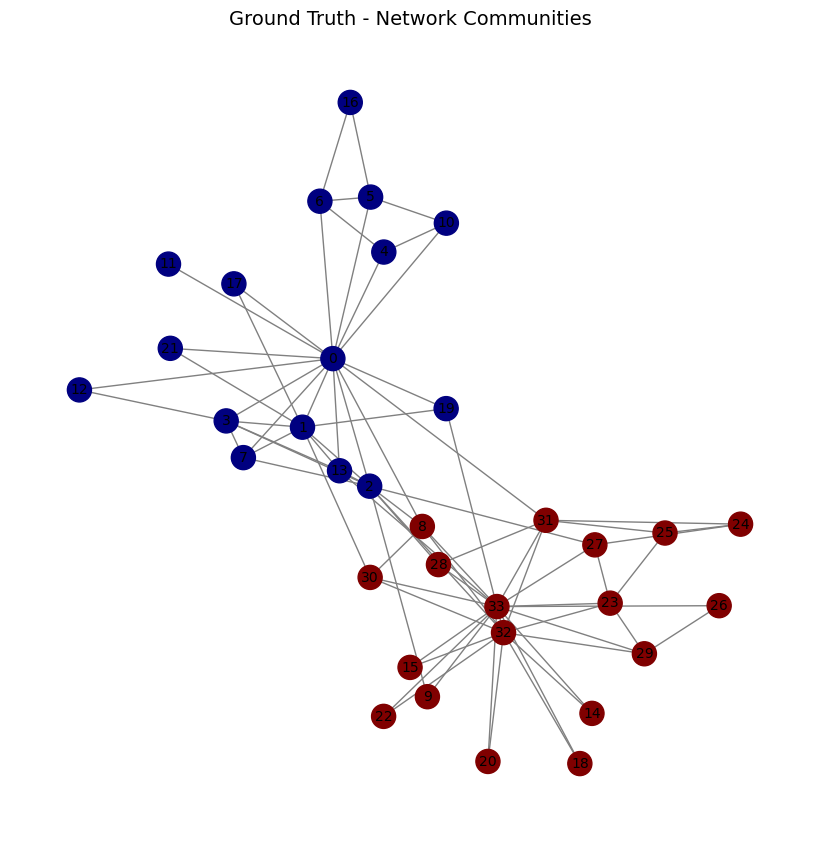

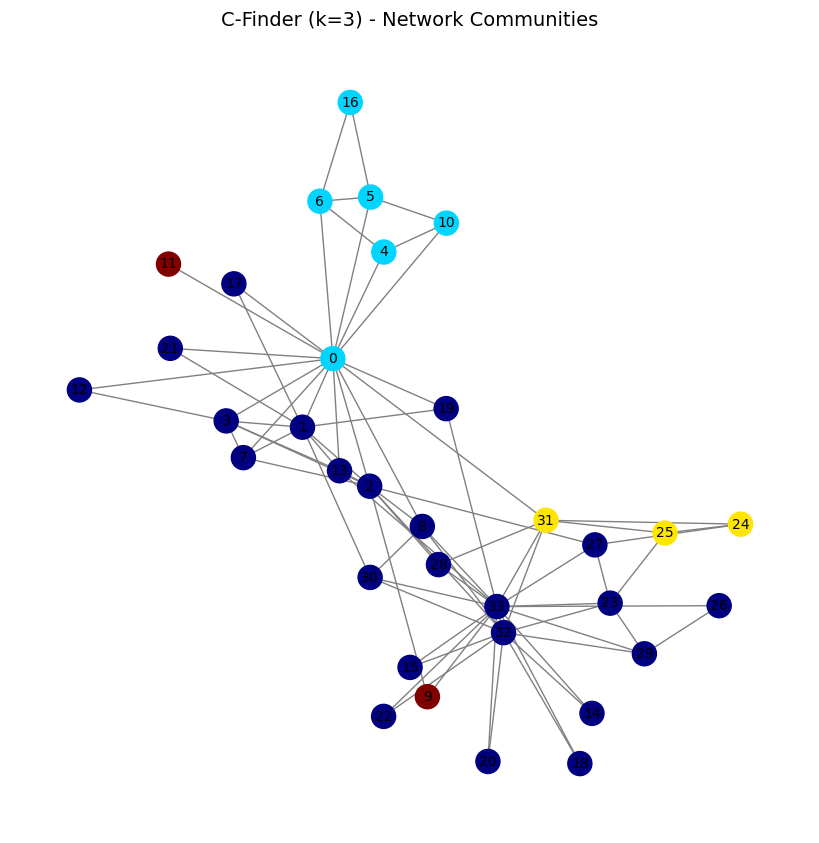

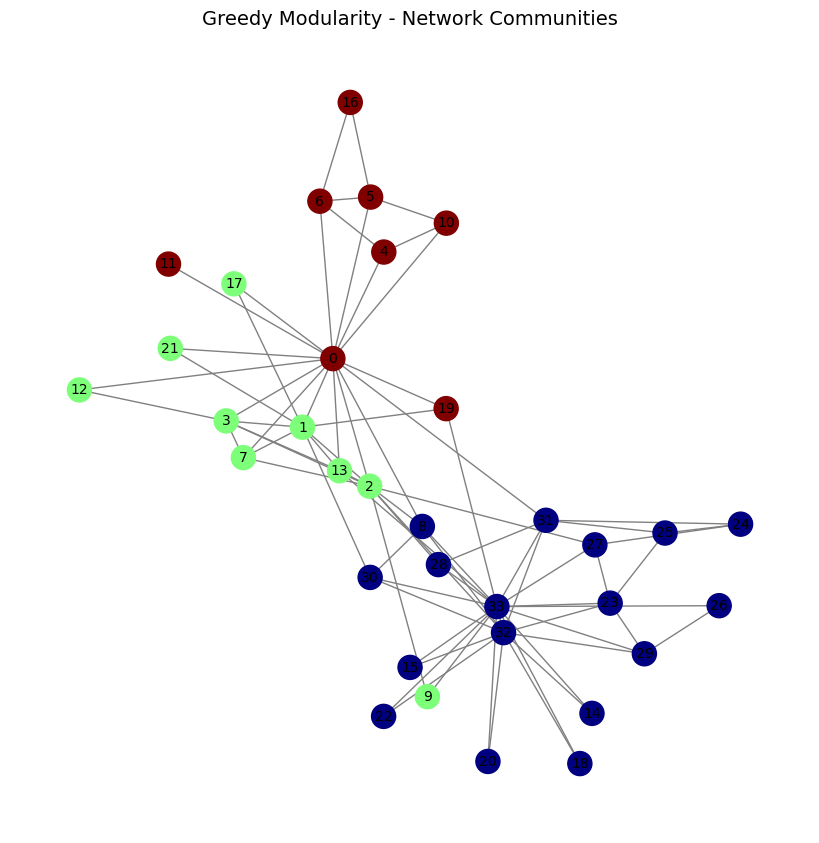

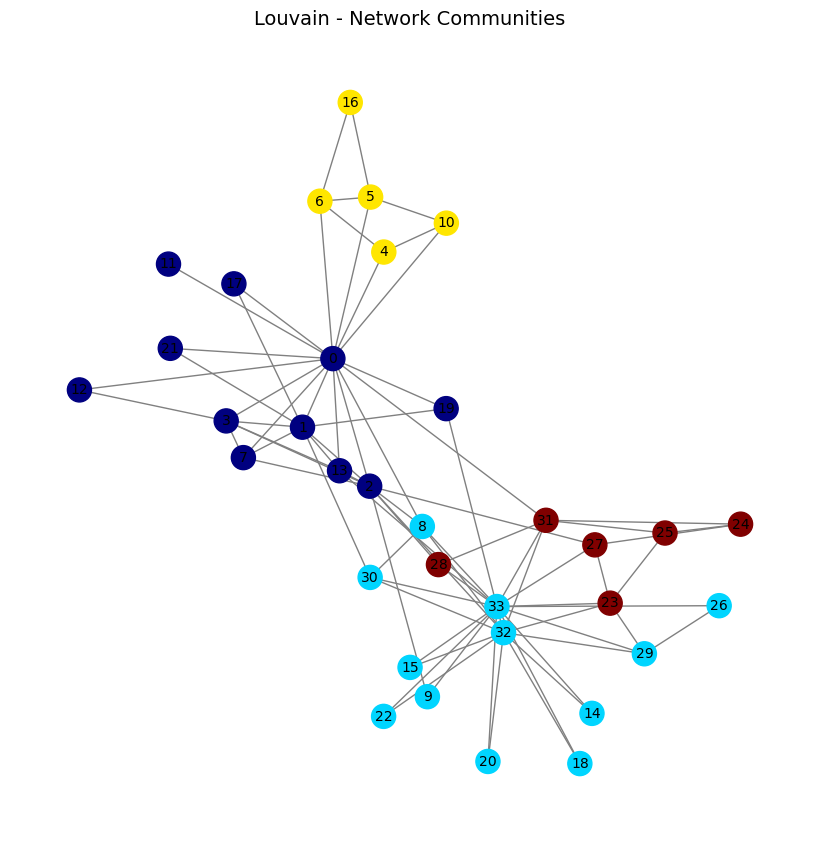

In [35]:
import networkx as nx
import numpy as np
from networkx.algorithms.community import k_clique_communities

# ✅ **自动选择最优的 k 值**
def select_k_for_cfinder(G):
    """
    Dynamically select a valid k for C-Finder based on graph density.
    """
    n = G.number_of_nodes()
    density = nx.density(G)

    print(f"Graph density: {density:.4f}")

    max_valid_k = None

    # 计算不同 k 的临界密度
    for k in range(3, min(10, n // 5)):  # 限制最大 k 值，防止溢出
        p_critical = np.power(n, -1.0 / (k - 1))
        print(f"k={k}, critical density={p_critical:.6f}")

        if density > p_critical:
            max_valid_k = k

    # 选择合适的 k
    if max_valid_k is not None:
        print(f"Recommended k={max_valid_k} (largest k where density > critical_density)")
        return max_valid_k
    else:
        print("Graph is very sparse, recommend using k=3")
        return 3

# ✅ **C-Finder 计算社区**
def compute_cfinder_communities(G, k):
    """
    Compute C-Finder communities (k-clique percolation method).
    """
    # 检查 G 是否为空
    if G.number_of_nodes() == 0:
        return []

    # 计算 k-clique 社区
    communities = list(k_clique_communities(G, k))

    # 如果没有社区，返回 -1
    if not communities:
        return [-1] * len(G.nodes())  # 所有节点默认归为 -1

    # 生成社区标签
    community_dict = {}
    for i, community in enumerate(communities):
        for node in community:
            community_dict[node] = i

    # 赋值给所有节点
    community_assignments = [community_dict.get(node, -1) for node in G.nodes()]
    return community_assignments

# ✅ **绘制网络社区**
def plot_network_communities(G, community_assignments, algorithm_name):
    """
    Visualize community assignments in a graph.
    """
    import matplotlib.pyplot as plt

    # 生成颜色映射
    unique_comms = list(set(community_assignments))
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_comms)))
    community_colors = {comm: colors[i] for i, comm in enumerate(unique_comms)}

    # 生成节点颜色
    node_colors = [community_colors[comm] for comm in community_assignments]

    # 绘制网络
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_size=300, with_labels=True, node_color=node_colors, font_size=10, edge_color='gray')

    plt.title(f'{algorithm_name} - Network Communities', fontsize=14)
    plt.show()

# ✅ **主代码**
G = nx.karate_club_graph()

# 真实社区划分 (Ground Truth)
ground_truth = [0, 0, 0, 0, 0, 
                0, 0, 0, 1, 1, 
                0, 0, 0, 0, 1, 
                1, 0, 0, 1, 0, 
                1, 0, 1, 1, 1,
                1, 1, 1, 1, 1,
                1, 1, 1, 1]

# ✅ **自动选择最优 k**
k = select_k_for_cfinder(G)

# 计算不同算法的社区划分
cfinder_assignments = compute_cfinder_communities(G, k)
greedy_assignments = compute_greedy_communities(G)
louvain_assignments = compute_louvain_communities(G)

# 绘制不同算法的社区划分
plot_network_communities(G, ground_truth, 'Ground Truth')
plot_network_communities(G, cfinder_assignments, f'C-Finder (k={k})')
plot_network_communities(G, greedy_assignments, 'Greedy Modularity')
plot_network_communities(G, louvain_assignments, 'Louvain')


## Written Response for 2.3

Answer:

# Part 3: Community Detection with LFR Networks [25 points]

### 3.1

In [26]:
import networkx as nx

def generate_lfr_benchmark(mu: float):
    """
    Generate an LFR Benchmark Network with a specified mixing parameter `mu`.

    Inputs:
    mu: float (Mixing parameter, must be in (0,1))

    Returns:
    G: NetworkX Graph Object
    community_assignments: List[int]
    """
    # Ensure `mu` is within the valid range (0.1, 0.9) to avoid extreme values
    mu = max(0.1, min(0.9, mu))

    # Parameters for LFR graph generation
    n = 500
    tau1 = 2.5
    tau2 = 2
    average_degree = 5  # Use average_degree instead of min_degree to avoid issues
    min_community = 40
    seed = 10

    # Generate the LFR benchmark graph
    G = nx.LFR_benchmark_graph(
        n, tau1=tau1, tau2=tau2, mu=mu,
        average_degree=average_degree,
        min_community=min_community,
        seed=seed
    )

    # Convert community sets to unique community IDs
    node_to_community = {}
    community_id = 0

    for node in G.nodes():
        for comm in G.nodes[node]['community']:
            if comm not in node_to_community:
                node_to_community[comm] = community_id
                community_id += 1
        # Assign the first (arbitrary) community ID to the node
        G.nodes[node]['community'] = node_to_community[next(iter(G.nodes[node]['community']))]

    # Extract community assignments
    community_assignments = [G.nodes[node]['community'] for node in G.nodes]

    return G, community_assignments

### 3.2

In [27]:
import numpy as np
from collections import Counter

def normalized_mutual_information(y_true, y_pred):
    """
    Compute Normalized Mutual Information (NMI) between two cluster assignments.

    Inputs:
    y_true: list[int] - Ground truth labels.
    y_pred: list[int] - Predicted cluster labels.

    Returns:
    NMI: float - Normalized Mutual Information score.
    """

    # 计算熵 H(U) 和 H(V)
    def entropy(labels):
        label_counts = Counter(labels)
        total = len(labels)
        return -sum((count / total) * np.log2(count / total) for count in label_counts.values())

    # 计算互信息 I(U, V)
    true_counts = Counter(y_true)
    pred_counts = Counter(y_pred)
    total = len(y_true)
    
    joint_counts = Counter(zip(y_true, y_pred))
    mi = sum(
        (count / total) * np.log2((count / total) / (true_counts[u] / total * pred_counts[v] / total))
        for (u, v), count in joint_counts.items()
    )

    # 计算 NMI
    H_true = entropy(y_true)
    H_pred = entropy(y_pred)

    return 2 * mi / (H_true + H_pred) if (H_true + H_pred) > 0 else 0.0


### 3.3

In [28]:
import numpy as np

def sweep_mu_values():
    """
    Sweeps mu values from 0.1 to 1.0 and evaluates the NMI for Greedy and Louvain methods.

    Returns:
    greedy_nmis: list[float]
    louvain_nmis: list[float]
    """
    greedy_nmis = []
    louvain_nmis = []

    # 确保 mu 值与 A3 需求一致（10 个点，0.1 到 1.0）
    mu_values = np.linspace(0.1, 1.0, 10)

    for mu in mu_values:
        try:
            # 生成 LFR 真实社区
            G, ground_truth = generate_lfr_benchmark(mu)

            # 计算 Greedy 社区
            greedy_assignments = compute_greedy_communities(G)
            greedy_nmi = normalized_mutual_information(ground_truth, greedy_assignments)
            greedy_nmis.append(greedy_nmi)

            # 计算 Louvain 社区
            louvain_assignments = compute_louvain_communities(G)
            louvain_nmi = normalized_mutual_information(ground_truth, louvain_assignments)
            louvain_nmis.append(louvain_nmi)

        except Exception as e:
            print(f"Error processing mu={mu}: {e}")
            greedy_nmis.append(np.nan)  # 避免数据结构出错
            louvain_nmis.append(np.nan)
            continue

    print("Greedy NMI values:", greedy_nmis)
    print("Louvain NMI values:", louvain_nmis)

    return greedy_nmis, louvain_nmis
# ✅ 运行 sweep_mu_values()，让它在内部处理 mu，而不是手动定义 mu
sweep_mu_values()

Greedy NMI values: [0.9712994659053138, 0.8111521630177659, 0.37348537354095457, 0.19401389661629717, 0.13212253280954506, 0.07278792095138989, 0.0514011104958669, 0.03301868092416046, 0.030675903844573315, 0.030675903844573315]
Louvain NMI values: [0.9751628441691755, 0.8140017450038002, 0.3521187245539866, 0.251125903534381, 0.13690935963868492, 0.059433578691095654, 0.052145857841806476, 0.03590619313611582, 0.02338809144700983, 0.022453689186118505]


([0.9712994659053138,
  0.8111521630177659,
  0.37348537354095457,
  0.19401389661629717,
  0.13212253280954506,
  0.07278792095138989,
  0.0514011104958669,
  0.03301868092416046,
  0.030675903844573315,
  0.030675903844573315],
 [0.9751628441691755,
  0.8140017450038002,
  0.3521187245539866,
  0.251125903534381,
  0.13690935963868492,
  0.059433578691095654,
  0.052145857841806476,
  0.03590619313611582,
  0.02338809144700983,
  0.022453689186118505])

### 3.4

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nmi_values(greedy_nmis, louvain_nmis, save=False):
    """
    Plot the NMI values for Greedy Modularity and Louvain across different mu values.

    Inputs:
    greedy_nmis: list[float] - NMI scores for Greedy Modularity
    louvain_nmis: list[float] - NMI scores for Louvain
    save: bool - Whether to save the plot as an image
    """

    # **确保 `mu_values` 生成 10 个点，与 `sweep_mu_values()` 一致**
    mu_values = np.linspace(0.1, 1.0, 10)

    if len(greedy_nmis) != len(mu_values) or len(louvain_nmis) != len(mu_values):
        print(f"Error: The length of greedy_nmis ({len(greedy_nmis)}) or louvain_nmis ({len(louvain_nmis)}) does not match mu_values ({len(mu_values)}).")
        return

    greedy_nmis = np.array(greedy_nmis)
    louvain_nmis = np.array(louvain_nmis)
    mu_values = np.array(mu_values)

    # Identify NaN values
    greedy_nan_mask = np.isnan(greedy_nmis)
    louvain_nan_mask = np.isnan(louvain_nmis)

    # Create a new figure
    plt.figure(figsize=(8, 6))

    # Plot Greedy Modularity NMI values
    plt.plot(mu_values, greedy_nmis, label='Greedy Modularity', marker='o', linestyle='-', color='b')

    # Mark NaN points for Greedy
    if np.any(greedy_nan_mask):
        plt.scatter(mu_values[greedy_nan_mask], greedy_nmis[greedy_nan_mask], color='gray', marker='o', label='Greedy (Failed)')

    # Plot Louvain NMI values
    plt.plot(mu_values, louvain_nmis, label='Louvain', marker='x', linestyle='--', color='r')

    # Mark NaN points for Louvain
    if np.any(louvain_nan_mask):
        plt.scatter(mu_values[louvain_nan_mask], louvain_nmis[louvain_nan_mask], color='gray', marker='x', label='Louvain (Failed)')

    # Add labels and title
    plt.xlabel('Mu (Mixing Parameter)', fontsize=12)
    plt.ylabel('Normalized Mutual Information (NMI)', fontsize=12)
    plt.title('NMI Comparison: Greedy Modularity vs Louvain', fontsize=14)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

    # Save the plot if requested
    if save:
        plt.savefig('NMI_comparison_Greedy_vs_Louvain.png', dpi=300, bbox_inches='tight')

    # Close the plot
    plt.close()


### 3.5

Greedy NMI values: [0.9712994659053138, 0.8111521630177659, 0.37348537354095457, 0.19401389661629717, 0.13212253280954506, 0.07278792095138989, 0.0514011104958669, 0.03301868092416046, 0.030675903844573315, 0.030675903844573315]
Louvain NMI values: [0.9703937944621196, 0.8145164599049955, 0.39391696791449665, 0.2556272925722866, 0.13258192832134805, 0.05408852942852485, 0.04333147459481935, 0.03483912509980574, 0.025982573562090376, 0.018052471250763303]


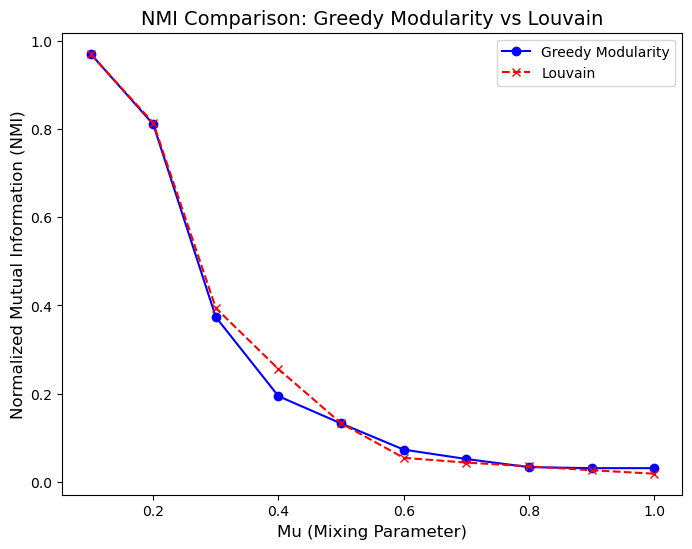

In [30]:
greedy_nmis, louvain_nmis = sweep_mu_values()

plot_nmi_values(greedy_nmis, louvain_nmis)

## Written Response for 3.5

Answer:

# Part 4: Community Detection on Real World Data [15 points]

### 4.1

In [15]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import community.community_louvain as community

def calculate_community_sizes(G):
    """
    Compute the sizes of communities detected by Greedy Modularity and Louvain methods.

    Inputs:
    G: NetworkX Graph Object

    Returns: 
    greedy_sizes: list[int] - Sizes of communities detected by Greedy Modularity.
    louvain_sizes: list[int] - Sizes of communities detected by Louvain.
    """

    # Greedy Modularity Communities
    greedy_communities = list(greedy_modularity_communities(G))
    greedy_sizes = [len(community) for community in greedy_communities]

    # Ensure the graph is undirected for Louvain
    if isinstance(G, nx.DiGraph):
        G = G.to_undirected()

    # Louvain Communities
    partition = community.best_partition(G)

    # Convert partition dictionary to list of communities
    community_dict = {}
    for node, comm in partition.items():
        community_dict.setdefault(comm, set()).add(node)
    louvain_comms = list(community_dict.values())

    louvain_sizes = [len(community) for community in louvain_comms]

    # Debugging Output
    print(f"Greedy communities: {len(greedy_sizes)} total, sizes: {greedy_sizes[:5]}...")
    print(f"Louvain communities: {len(louvain_sizes)} total, sizes: {louvain_sizes[:5]}...")

    return greedy_sizes, louvain_sizes


### 4.2

In [16]:
import matplotlib.pyplot as plt

def plot_community_size_distributions(greedy_sizes, louvain_sizes, data_name, save=False):
    """
    Plot and compare the community size distributions for Greedy Modularity and Louvain methods.

    Inputs:
    greedy_sizes: list[int] - Sizes of communities detected by Greedy Modularity.
    louvain_sizes: list[int] - Sizes of communities detected by Louvain.
    data_name: str - Name of the dataset (e.g., "Airport", "Yeast").
    save: bool - Whether to save the plot as an image.
    """

    # Create a new figure
    plt.figure(figsize=(8, 6))

    # Plot histogram for Greedy Modularity community sizes
    plt.hist(greedy_sizes, bins=20, alpha=0.6, label='Greedy Modularity', color='b', edgecolor='black', histtype="stepfilled")

    # Plot histogram for Louvain community sizes
    plt.hist(louvain_sizes, bins=20, alpha=0.6, label='Louvain', color='r', edgecolor='black', histtype="stepfilled")

    # Adjust x-axis limits to avoid excessive empty space
    plt.xlim(0, max(max(greedy_sizes), max(louvain_sizes)) * 1.1)

    # Add labels and title
    plt.xlabel('Community Size', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Community Size Distributions: {data_name}', fontsize=14)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

    # Save the plot if 'save' is True
    if save:
        plt.savefig(f'{data_name}_community_size_distribution.png', dpi=300, bbox_inches="tight")

    # Close the plot to avoid display in subsequent cells
    plt.close()


### 4.3

Greedy communities: 16 total, sizes: [644, 395, 352, 97, 57]...
Louvain communities: 17 total, sizes: [546, 16, 349, 124, 238]...


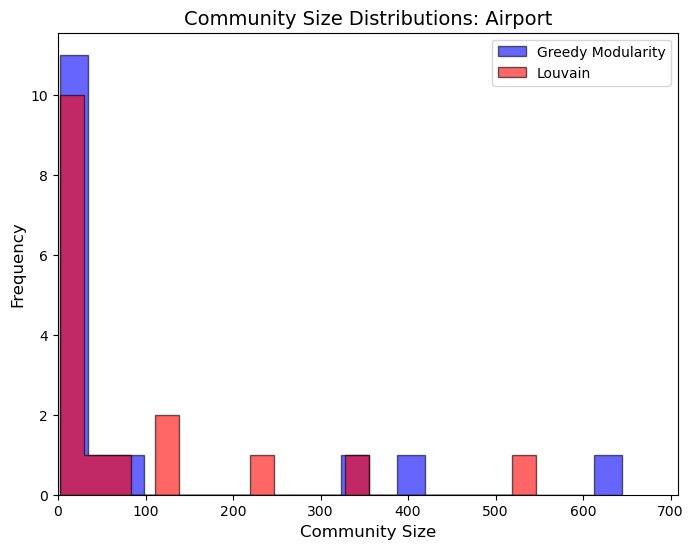

Greedy communities: 27 total, sizes: [96, 88, 78, 68, 60]...
Louvain communities: 27 total, sizes: [74, 30, 23, 26, 56]...


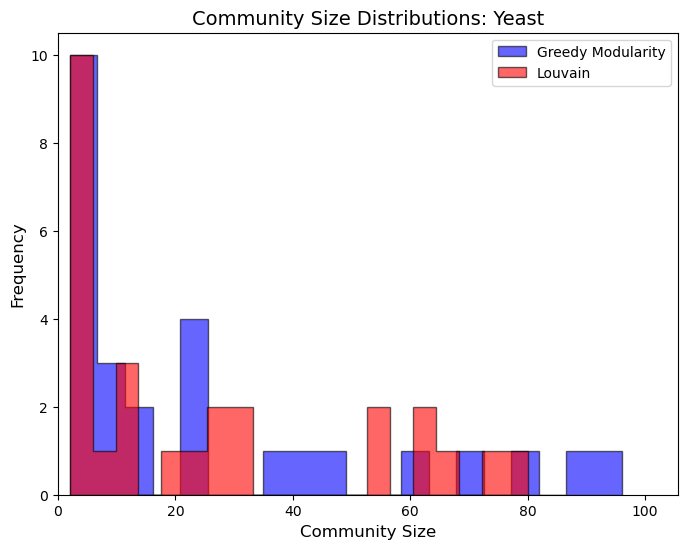

In [17]:
G_airport, G_yeast = load_graphs()

# Airport
greedy_sizes, louvain_sizes = calculate_community_sizes(G_airport)
plot_community_size_distributions(greedy_sizes, louvain_sizes, 'Airport')

# Yeast
greedy_sizes, louvain_sizes = calculate_community_sizes(G_yeast)
plot_community_size_distributions(greedy_sizes, louvain_sizes, 'Yeast')

## Written Response for 4.3

Answer:

## Response for 5



### Partition 1:

Image:

Modularity:

### Partition 2:

Image:

Modularity:

### Partition 3:

Image:

Modularity:

### Partition 4:

Image:

Modularity:

In [36]:
import networkx as nx
from networkx.algorithms.community import modularity

def compute_modularity(G, community_assignments):
    """
    Compute the modularity score Q for a given partition.

    Inputs:
    G: NetworkX Graph Object
    community_assignments: list[int] - List of community indices for each node.

    Returns:
    Q: float - Modularity score.
    """
    # 转换 community_assignments 为 NetworkX 需要的格式
    community_dict = {}
    for node, comm in enumerate(community_assignments):
        if comm not in community_dict:
            community_dict[comm] = []
        community_dict[comm].append(node)
    
    # 转换为 NetworkX 格式的社区列表
    communities = list(community_dict.values())


    # 计算模块度
    Q = modularity(G, communities)
    return Q


In [37]:
# 先正确生成 G 和 Ground Truth
G, ground_truth_assignments = generate_lfr_benchmark(mu=0.5)

# 确保所有的 community_assignments 变量都已定义
cfinder_assignments = compute_cfinder_communities(G, k=3)  # 你可能需要调整 k 值
greedy_assignments = compute_greedy_communities(G)
louvain_assignments = compute_louvain_communities(G)

# 计算 Partition 1-4 的模块度
Q_ground_truth = compute_modularity(G, ground_truth_assignments)
Q_cfinder = compute_modularity(G, cfinder_assignments)
Q_greedy = compute_modularity(G, greedy_assignments)
Q_louvain = compute_modularity(G, louvain_assignments)

# 打印模块度值
print(f"Ground Truth Modularity: {Q_ground_truth:.4f}")
print(f"C-Finder Modularity: {Q_cfinder:.4f}")
print(f"Greedy Modularity: {Q_greedy:.4f}")
print(f"Louvain Modularity: {Q_louvain:.4f}")


Ground Truth Modularity: 0.2741
C-Finder Modularity: 0.1126
Greedy Modularity: 0.3992
Louvain Modularity: 0.3930
